## Fermionic Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, RZGate
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise



In [35]:

# Number operator at site i
def number_operator(N, i):
    pauli_string = ['I' for _ in range(N)]
    pauli_string[i] = 'Z'
    op = SparsePauliOp([''.join(pauli_string[::-1])],[1.0])
    N_op = (-1)**(i+1)*(op.to_matrix() - (-1)**(i)*np.eye(2**N, dtype=complex)) / 2
    return N_op

# Total number density operator
def number_density(N):
    N_total = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        N_total += number_operator(N, i)
    return N_total*(1/N)

# Hamiltonian construction
def hamiltonian(N, w, m, e):

    dim  = 2**N

    terms = []

    #hopping term
    #xx neighbor interaction
    pauli_string = ['I' for _ in range(N)]
    for i in range(N-1):
        pauli_string[i] = 'X'
        pauli_string[i+1] = 'X'
        terms.append((''.join(pauli_string[::-1]),w/2))
        pauli_string[i] = 'I'
        pauli_string[i+1] = 'I'

    #yy neighbor interaction
    pauli_string = ['I' for _ in range(N)]
    for i in range(N-1):
        pauli_string[i] = 'Y'
        pauli_string[i+1] = 'Y'
        terms.append((''.join(pauli_string[::-1]),w/2))
        pauli_string[i] = 'I'
        pauli_string[i+1] = 'I'

    #mass term
    for i in range(N):
        pauli_string[i] = 'Z'
        terms.append((''.join(pauli_string[::-1]), m/2 * (-1)**(i+1) ))
        pauli_string[i] = 'I'
    
    # electric field term

    # cross term with background field
    for i in range(N-1):
        pauli_string[i] = 'Z'
        
        terms.append((''.join(pauli_string[::-1]),(N - 1 - i) * e ))
        pauli_string[i] = 'I'

    # charge squared term
    for i in range(N-1):
        pauli_string[i] = 'Z'
        terms.append((''.join(pauli_string[::-1]),-1*(-1)**(i)*(N-1-i)/2))
        pauli_string[i] = 'I'

        for j in range(i):
            pauli_string[j] = 'Z'
            terms.append((''.join(pauli_string[::-1]),-1*(-1)**(i)*(N-1-i)/2))
            pauli_string[j] = 'I'

            pauli_string[i] = 'Z'
            terms.append((''.join(pauli_string[::-1]),-1*(-1)**(j)*(N-1-i)/2))
            pauli_string[i] = 'I'

            pauli_string[i] = 'Z'
            pauli_string[j] = 'Z'
            terms.append((''.join(pauli_string[::-1]), (N-1-i)/2))
            pauli_string[i] = 'I'
            pauli_string[j] = 'I'

    
    return SparsePauliOp.from_list(terms)

# Trotter layer appending
def append_trotter_layer(qc, N, hamiltonian_op, dt):
    xx_gates = []
    yy_gates = []
    zz_gates = []
    z_gates = []

    for pauli_str, coeff in hamiltonian_op.label_iter():
        active = [i for i, c in enumerate(reversed(pauli_str)) if c != 'I']
        p_type = "".join([c for c in reversed(pauli_str) if c != 'I'])
        theta = 2 * coeff.real * dt

        
        if p_type == "XX":
            xx_gates.append((theta, active[0], active[1]))

        elif p_type == "YY":
            yy_gates.append((theta, active[0], active[1]))

        elif p_type == "ZZ": 
            zz_gates.append((theta, active[0], active[1]))
        
        elif p_type == "Z":
            z_gates.append((theta, active[0]))

    #uncomment below to use new charge conserving trotter decomposition instead of rxx,ryy gates

    # for gate in xx_gates:
    #     qc.rz(np.pi/4,gate[1])
    #     qc.rz(-np.pi/4,gate[2])
    #     qc.h(gate[1])
    #     qc.cx(gate[1],gate[2])
    #     qc.ry(gate[0],gate[1])
    #     qc.ry(gate[0],gate[2])
    #     qc.cx(gate[1],gate[2]) 
    #     qc.h(gate[1])
    #     qc.rz(-np.pi/4,gate[1])
    #     qc.rz(np.pi/4,gate[2])

 
    # comment rxx and ryy loops if using the new trotter decomposition 
    for gate in xx_gates:
        qc.rxx( gate[0], gate[1], gate[2])

    for gate in yy_gates:
        qc.ryy( gate[0], gate[1], gate[2])

    for gate in zz_gates:
        qc.rzz( gate[0], gate[1], gate[2])

    for gate in z_gates:
        qc.rz( gate[0],gate[1])


# convert bitstring label to statevector (used for exact evolution)
def state_from_label(label, N):
    dim = 2**N
    state = np.zeros((dim, 1), dtype=complex)
    index = int(label, 2)
    state[index, 0] = 1.0
    return state

# Quantum circuit for time evolution using Trotterization
def quantum_exp(N,hamiltonian_op,state, Nt,dt):
    qc = QuantumCircuit(N,N)
    for i, char in enumerate(state[::-1]):
        if char == '1': qc.x(i)
    qc_trotter = QuantumCircuit(N)
    for i in range(Nt):
        append_trotter_layer(qc_trotter,N,hamiltonian_op,dt)
    qc = qc.compose(qc_trotter,qubits = range(N))
    qc.measure(range(N),range(N))
    return qc

# Convert bitstring label to particle number density
def label_to_particle_number(str):
    number = 0
    for i,c in enumerate(str):
        number += int(c,2)*(-1)**(i+1) + (1 + (-1)**i)/2
    l = len(str)
    return number/l


Starting Exact Time Evolution...
Starting Trotter Time Evolution...
Starting Qauntum Experiment...
Simulation complete. Plot saved as 'string_breaking_plot.png'


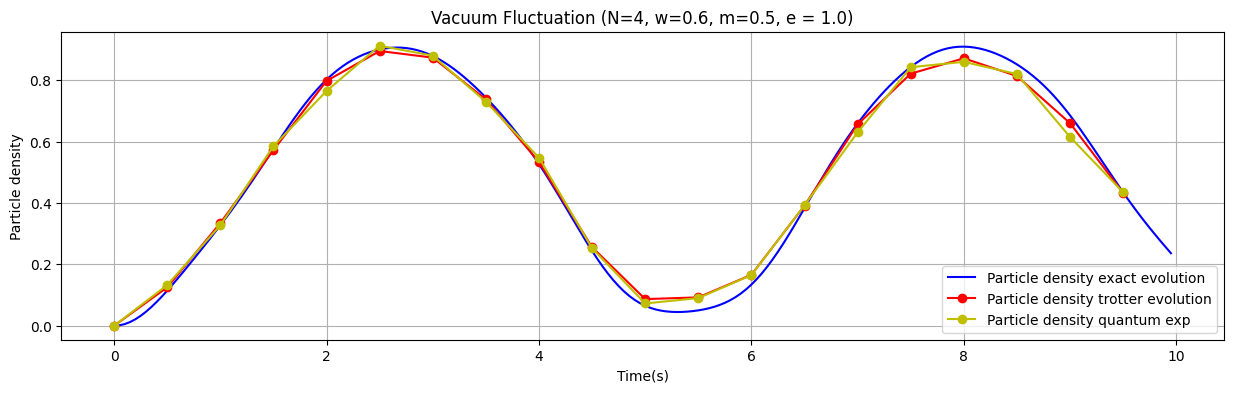

In [36]:
# --- Simulation Parameters and Execution ---

N = 4       # number of sites
w = 0.6     # hopping parameter
m = 0.5     # mass parameter
e = 1.0     # background electric field 

# vacuum state is '1010', for string breaking use state '0011'
# notice that the sites are indexed from right to left as qiskit uses the least significant bit first

state = '1010'  
 
shots = 200  # number of shots for quantum experiment

H_terms = hamiltonian(N, w, m, e)

T = 10  # total time
steps_trotter = 20   # number of trotter steps
dt_trotter = (T)/steps_trotter
times_trotter = np.arange(0, T, dt_trotter)

steps_exact = 200  # number of steps for exact evolution
dt_exact = T/steps_exact
times_exact = np.arange(0, T, dt_exact)

particle_at_sites_exact = []
particle_at_sites_trotter = []
particle_at_sites_quant = []

particle_counts_exact = []
particle_counts_trotter = []
particle_counts_exp = []

charge_exact = []
charge_trotter = []
charge_exp = []

H_matrix = H_terms.to_matrix()

from scipy.linalg import expm
U_exact = expm(-1j * H_matrix * dt_exact)

initial_state = state_from_label(state,N)
current_state = initial_state


print("Starting Exact Time Evolution...")

for t in times_exact:
    part_at_sites = []
    charge_at_sites = []
    for i in range(N):
        n = np.real(np.conj(current_state.T) @ number_operator(N,i) @ current_state)[0,0]
        part_at_sites.append(n)
        charge_at_sites.append(n*(-1)**i)
    particle_at_sites_exact.append(part_at_sites)
    charge_exact.append(sum(charge_at_sites))
    particle_counts_exact.append(sum(part_at_sites)/N)

    current_state = U_exact @ current_state

initial_state = Statevector.from_label(state)

current_state = initial_state


print("Starting Trotter Time Evolution...")
for t in times_trotter:
    # Calculate observable
    prob = abs(current_state.inner(initial_state))**2
    part_at_sites = [0 for _ in range(N)]
    dic = current_state.to_dict()
    part_at_sites = [0 for _ in range(N)]
    charge_at_sites = [0 for _ in range(N)]
    for key in dic.keys():
        for i,char in enumerate(key):
            n = (int(char,2)*(-1)**(i+1) + (1 + (-1)**i)/2)*abs(dic[key])**2
            part_at_sites[i] += n
            charge_at_sites[i] += n*(-1)**i
    particle_at_sites_trotter.append(part_at_sites)
    charge_trotter.append(sum(charge_at_sites))
    particle_counts_trotter.append(sum(part_at_sites)/N)

    qc_step = QuantumCircuit(N)
    append_trotter_layer(qc_step, N, H_terms, dt_trotter)
    step_op = Operator(qc_step)
    current_state = current_state.evolve(step_op)

# --- Plotting ---


# Error probabilities
prob = 0.01 # 1-qubit gate

# Depolarizing quantum errors
error = noise.depolarizing_error(prob, 1)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['ry'])  # adding error to ry gates as an example

print("Starting Qauntum Experiment...")
for Nt,t in enumerate(times_trotter):
    qc = quantum_exp(N,H_terms,state,Nt,dt_trotter)
    # sim = AerSimulator(noise_model = noise_model)   # uncomment this line to include noise model
    sim = AerSimulator()
    transpiled = transpile(qc, sim)
    result = sim.run(transpiled, shots=shots).result()
    counts = result.get_counts()
    part_at_sites = [0 for i in range(N)]
    charge_at_sites = [0 for _ in range(N)]
    for key in counts.keys():
        for i,char in enumerate(key):
            n = (int(char,2)*(-1)**(i+1) + (1 + (-1)**i)/2)*counts[key]/shots
            part_at_sites[i] += n
            charge_at_sites[i] += n*(-1)**i
    particle_at_sites_quant.append(part_at_sites)
    charge_exp.append(sum(charge_at_sites))
    particle_counts_exp.append(sum(part_at_sites)/N)



plt.figure(figsize=(15, 4))

plt.plot(times_exact, particle_counts_exact, 'b-', label='Particle density exact evolution')
plt.plot(times_trotter, particle_counts_trotter, 'r-o', label='Particle density trotter evolution')
plt.plot(times_trotter, particle_counts_exp, 'y-o', label='Particle density quantum exp')

plt.title(f'Vacuum Fluctuation (N={N}, w={w}, m={m}, e = {e})')
plt.xlabel('Time(s)')
plt.ylabel('Particle density')
plt.legend()
plt.grid(True)
plt.savefig('string_breaking_plot.png')
print("Simulation complete. Plot saved as 'string_breaking_plot.png'")

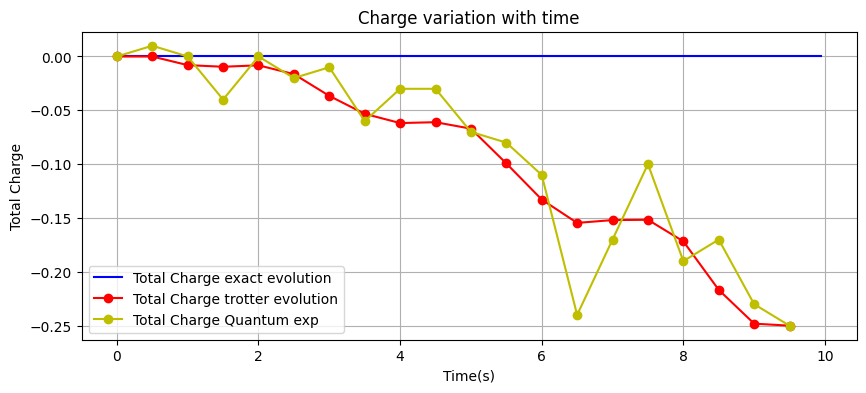

In [37]:
plt.figure(figsize=(10, 4))

plt.plot(times_exact, charge_exact, 'b-', label='Total Charge exact evolution')
plt.plot(times_trotter, charge_trotter, 'r-o', label='Total Charge trotter evolution')
plt.plot(times_trotter, charge_exp, 'y-o', label='Total Charge Quantum exp')
plt.xlabel('Time(s)')
plt.ylabel('Total Charge')
plt.title('Charge variation with time')
plt.legend()
plt.grid(True)
plt.show()

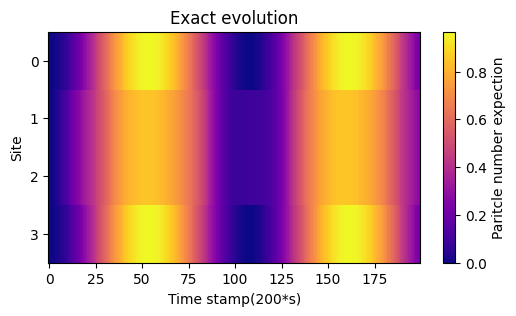

In [38]:

plt.figure(figsize=(6, 3))
plt.imshow(np.array(particle_at_sites_exact).T,aspect='auto',interpolation='nearest',cmap="plasma")
plt.colorbar(label = "Paritcle number expection")
plt.xlabel(f'Time stamp({steps_exact}*s)')
plt.ylabel('Site')
plt.title('Exact evolution')
plt.yticks(range(N))
plt.show()

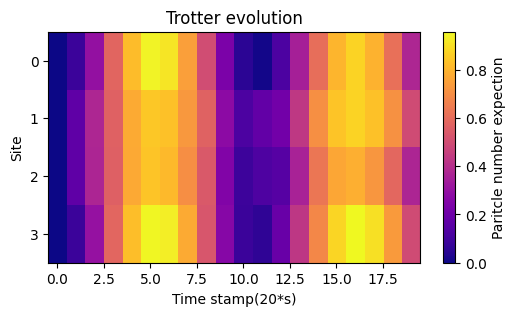

In [40]:

plt.figure(figsize=(6, 3))
plt.imshow(np.array(particle_at_sites_trotter).T,aspect='auto',interpolation='nearest',cmap="plasma")
plt.colorbar(label = "Paritcle number expection")
plt.xlabel(f'Time stamp({steps_trotter}*s)')
plt.ylabel('Site')
plt.title('Trotter evolution')
plt.yticks(range(N))
plt.show()

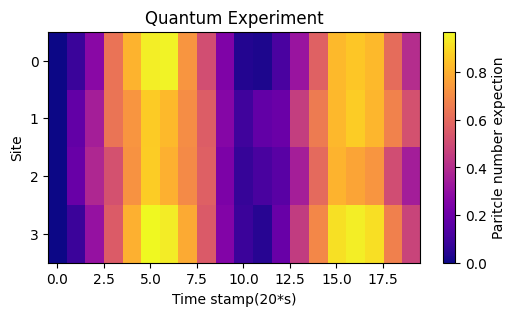

In [41]:

plt.figure(figsize=(6, 3))
plt.imshow(np.array(particle_at_sites_quant).T,aspect='auto',interpolation='nearest',cmap="plasma")
plt.colorbar(label = "Paritcle number expection")
plt.xlabel(f'Time stamp({steps_trotter}*s)')
plt.title('Quantum Experiment')
plt.ylabel('Site')
plt.yticks(range(N))
plt.show()

## Bosonic Simulations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import expm_multiply, eigsh
from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector, partial_trace, entropy
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from tqdm import tqdm
import os
import sys

# Create output directory
os.makedirs("results_final", exist_ok=True)

# ==============================================================================
# PART A: COMPLETE.PY LOGIC (Plots 2, 3, 4)
# ==============================================================================

params_complete = {
    "N_SITES": 9,
    "N_LEVELS": 4,
    "N_QUBITS_PER_SITE": 2,
    "A": 1.0,
    "MU": 0.5,
    "W0": 1.0,
    "T_MAX": 10.0,
    "DT": 0.05,
    "SHOTS": 2000,
    "STRING_MAG": 1.5
}

class SchwingerOperators:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        
        # A. Local Matrix Operators
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        
        self.phi_mat = (1.0 / np.sqrt(2 * p["W0"])) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(p["W0"] / 2.0) * (self.a_mat - self.adag_mat)

        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)

        # B. Sparse Global Hamiltonian
        # print("Building sparse Hamiltonian...")
        self.H_sparse = self._build_sparse_hamiltonian()

        # C. Qiskit Operators
        # print("Building Pauli operators...")
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi_op = SparsePauliOp.from_operator(Operator(self.pi_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.int_op = self.phi_op.tensor(self.phi_op)

    def _build_sparse_hamiltonian(self):
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        
        c_kin = 0.5 * self.p["A"]
        c_mass = 0.5 * self.p["A"] * self.p["MU"]**2
        c_grad = 0.5 / self.p["A"]

        for i in range(N):
            term_k = self._embed_operator(self.pi2_mat, i)
            H += c_kin * term_k
            term_m = self._embed_operator(self.phi2_mat, i)
            H += c_mass * term_m
            n_neighbors = 1 if (i == 0 or i == N-1) else 2
            H += c_grad * n_neighbors * term_m

        for i in range(N - 1):
            op_list = [self.id_mat] * N
            op_list[i] = self.phi_mat
            op_list[i+1] = self.phi_mat
            term_int = op_list[0]
            for k in range(1, N):
                term_int = kron(term_int, op_list[k], format='csr')
            H -= (1.0 / self.p["A"]) * term_int
        return H

    def _embed_operator(self, op, site_idx):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site_idx] = op
        full_op = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full_op = kron(full_op, ops[k], format='csr')
        return full_op

    def get_initial_state_vector(self, system_type):
        N = self.p["N_SITES"]
        vac = np.zeros(self.dim); vac[0] = 1.0
        alpha = self.p["STRING_MAG"]
        string_state = expm_multiply(alpha * self.adag_mat - np.conj(alpha) * self.a_mat, vac)
        full_psi = np.array([1.0])
        
        if system_type == 1:
            # print("Initializing String between site 3 and 6")
            for i in range(N):
                if 3 <= i < 6: 
                    full_psi = np.kron(full_psi, string_state)
                else:
                    full_psi = np.kron(full_psi, vac)
        elif system_type == 2:
            # print("Initializing Point Charge at site 4")
            for i in range(N):
                if i >= 4:
                    full_psi = np.kron(full_psi, string_state)
                else:
                    full_psi = np.kron(full_psi, vac)
        return full_psi

    def site_qubits(self, site_idx):
        N = self.p["N_SITES"]
        nq = self.p["N_QUBITS_PER_SITE"]
        start = (N - 1 - site_idx) * nq
        return list(range(start, start + nq))

    def build_trotter_circuit(self, dt):
        N = self.p["N_SITES"]
        nq = self.p["N_QUBITS_PER_SITE"]
        qc = QuantumCircuit(N * nq)
        c_kin = 0.5 * self.p["A"]
        c_mass = 0.5 * self.p["A"] * self.p["MU"]**2
        c_grad = 0.5 / self.p["A"]
        c_int = -1.0 / self.p["A"]

        def get_qubits(site_idx):
            start = (N - 1 - site_idx) * nq
            return list(range(start, start + nq))

        for i in range(N):
            q_indices = get_qubits(i)
            qc.append(PauliEvolutionGate(self.pi2_op, time=c_kin * dt), q_indices)
            
        for i in range(N):
            q_indices = get_qubits(i)
            n_bonds = 1 if (i==0 or i==N-1) else 2
            coeff = c_mass + n_bonds * c_grad
            qc.append(PauliEvolutionGate(self.phi2_op, time=coeff * dt), q_indices)
            
        for i in range(N - 1):
            q_i = get_qubits(i)
            q_next = get_qubits(i+1)
            q_indices = q_i + q_next 
            qc.append(PauliEvolutionGate(self.int_op, time=c_int * dt), q_indices)
            
        return qc

def run_simulations_complete(ops, system_type):
    psi_0 = ops.get_initial_state_vector(system_type)
    TIMES = np.arange(0, ops.p["T_MAX"] + ops.p["DT"], ops.p["DT"])
    
    results = {
        "time": TIMES,
        "bench_field": [],
        "trot_field": [],
        "shot_field": [],
        "bench_current": [],
        "trot_current": [],
        "shot_current": [],
        "bench_energy": []
    }
    
    print(f"Running Benchmark (Exact) for System {system_type}...")
    psi_t = psi_0.copy()
    
    def get_local_exp(vec, op, site):
        dim = ops.dim
        n = ops.p["N_SITES"]
        shape = (dim**site, dim, dim**(n-1-site))
        v_reshaped = vec.reshape(shape)
        v_prime = np.tensordot(v_reshaped, op, axes=([1], [1]))
        v_prime = np.transpose(v_prime, (0, 2, 1))
        return np.vdot(vec.flatten(), v_prime.flatten()).real

    for t in tqdm(TIMES):
        fields = [get_local_exp(psi_t, ops.phi_mat, i) for i in range(ops.p["N_SITES"])]
        results["bench_field"].append(fields)
        currents = [- (fields[i+1] - fields[i]) for i in range(len(fields)-1)]
        results["bench_current"].append(currents)
        en = np.vdot(psi_t, ops.H_sparse @ psi_t).real
        results["bench_energy"].append(en)
        
        if t < TIMES[-1]:
            psi_t = expm_multiply(-1j * ops.H_sparse * ops.p["DT"], psi_t)

    print(f"Running Trotter (Statevector) for System {system_type}...")
    qs_0 = Statevector(psi_0)
    step_circ = ops.build_trotter_circuit(ops.p["DT"])
    curr_qs = qs_0
    
    for t in tqdm(TIMES):
        fields = []
        for i in range(ops.p["N_SITES"]):
            q_indices = ops.site_qubits(i)
            val = curr_qs.expectation_value(ops.phi_op, qargs=q_indices).real
            fields.append(val)
        results["trot_field"].append(fields)
        currents = [- (fields[i+1] - fields[i]) for i in range(len(fields)-1)]
        results["trot_current"].append(currents)
        
        if t < TIMES[-1]:
            curr_qs = curr_qs.evolve(step_circ)

    print(f"Running Quantum Simulation (Shots={ops.p['SHOTS']}) for System {system_type}...")
    
    observables = []
    for i in range(ops.p["N_SITES"]):
        start = (ops.p["N_SITES"] - 1 - i) * ops.p["N_QUBITS_PER_SITE"]
        full_op = ops.phi_op
        if start > 0:
            full_op = full_op.tensor(SparsePauliOp("I" * start))
        remaining = (ops.p["N_SITES"] * ops.p["N_QUBITS_PER_SITE"]) - (start + ops.p["N_QUBITS_PER_SITE"])
        if remaining > 0:
            full_op = SparsePauliOp("I" * remaining).tensor(full_op)
        observables.append(full_op)

    sim_backend = AerSimulator()
    estimator = AerEstimator()
    estimator.options.default_shots = ops.p["SHOTS"]

    main_qc = QuantumCircuit(ops.p["N_SITES"] * ops.p["N_QUBITS_PER_SITE"])
    main_qc.initialize(psi_0, main_qc.qubits)
    
    for t in tqdm(TIMES, desc="EstimatorV2"):
        isa_circuit = transpile(main_qc, sim_backend)
        pub = (isa_circuit, observables)
        job = estimator.run([pub])
        result = job.result()
        fields = result[0].data.evs
            
        results["shot_field"].append(fields)
        currents = [- (fields[i+1] - fields[i]) for i in range(len(fields)-1)]
        results["shot_current"].append(currents)
        
        if t < TIMES[-1]:
            main_qc.append(step_circ, range(main_qc.num_qubits))

    return results

# ==============================================================================
# PART B: NOISY.PY LOGIC (Plots 7, 8, 9)
# ==============================================================================

class SchwingerBosonNoisy:
    def __init__(self, n, dim, a=1.0, e=1.0, m=0.5, theta=0.0):
        self.n, self.dim, self.a, self.e, self.m, self.theta = n, dim, a, e, m, theta
        self.mu = e / np.sqrt(np.pi)
        vals = np.sqrt(np.arange(1, dim))
        a_op = np.diag(vals, k=1)
        self.phi = (a_op + a_op.T.conj()) / np.sqrt(2)
        self.pi = 1j * (a_op.T.conj() - a_op) / np.sqrt(2)
        self.phi2, self.pi2 = self.phi @ self.phi, self.pi @ self.pi
        self.id = np.eye(dim)
        self.n_op = a_op.T.conj() @ a_op
        self.adag = a_op.T.conj()
        
        self.phi_pop = SparsePauliOp.from_operator(Operator(self.phi))
        self.pi2_pop = SparsePauliOp.from_operator(Operator(self.pi2))
        self.phi2_pop = SparsePauliOp.from_operator(Operator(self.phi2))
        self.n_pop = SparsePauliOp.from_operator(Operator(self.n_op))

    def embed(self, op, s, sparse=True):
        ops = [self.id if sparse else SparsePauliOp("I"*int(np.log2(self.dim)))] * self.n
        ops[s] = csr_matrix(op) if sparse else op
        full = ops[0]
        for k in range(1, self.n):
            full = kron(full, ops[k]) if sparse else full.tensor(ops[k])
        return full

    def get_H(self, ext_Q=None):
        H = csr_matrix((self.dim**self.n, self.dim**self.n), dtype=complex)
        ck, cg = 0.5/self.a, 0.5/self.a
        cm = 0.5 * self.a * self.mu**2
        ci = -0.2 * self.a * self.m * self.e
        
        for i in range(self.n):
            H += ck * self.embed(self.pi2, i) + cm * self.embed(self.phi2, i)
            th = self.theta - (2*np.pi*ext_Q[i] if ext_Q is not None else 0)
            arg = 2*np.sqrt(np.pi)*self.phi + th*self.id
            H += ci * self.embed(0.5*(expm(1j*arg)+expm(-1j*arg)), i)
            
        for i in range(self.n-1):
            H += cg*(self.embed(self.phi2,i) + self.embed(self.phi2,i+1))
            H -= 2*cg * (self.embed(self.phi, i) @ self.embed(self.phi, i+1))
        return H

    def get_trotter(self, dt, steps, ext_Q=None):
        qc = QuantumCircuit(self.n * int(np.log2(self.dim)))
        op_K, op_P, op_I = [SparsePauliOp(["I"*qc.num_qubits], coeffs=[0.0]) for _ in range(3)]
        
        ck, cg, cm = 0.5/self.a, 0.5/self.a, 0.5*self.a*self.mu**2
        ci = -0.2 * self.a * self.m * self.e

        for i in range(self.n):
            op_K += ck * self.embed(self.pi2_pop, i, False)
            th = self.theta - (2*np.pi*ext_Q[i] if ext_Q is not None else 0)
            arg = 2*np.sqrt(np.pi)*self.phi + th*self.id
            cos_op = SparsePauliOp.from_operator(Operator(0.5*(expm(1j*arg)+expm(-1j*arg))))
            n_b = 1 if i in [0, self.n-1] else 2
            op_P += (cm + n_b*cg) * self.embed(self.phi2_pop, i, False) + ci * self.embed(cos_op, i, False)

        for i in range(self.n-1):
            op_I += (-2*cg) * self.embed(self.phi_pop, i, False).compose(self.embed(self.phi_pop, i+1, False))

        step = QuantumCircuit(qc.num_qubits)
        for op in [op_K, op_P, op_I]: step.append(PauliEvolutionGate(op, time=dt), range(qc.num_qubits))
        for _ in range(steps): qc.append(step, range(qc.num_qubits))
        return qc

    def get_hamiltonian_op(self, ext_Q=None):
        qc = QuantumCircuit(self.n * int(np.log2(self.dim)))
        H_op = SparsePauliOp(["I"*qc.num_qubits], coeffs=[0.0])
        ck, cg, cm = 0.5/self.a, 0.5/self.a, 0.5*self.a*self.mu**2
        ci = -0.2 * self.a * self.m * self.e

        for i in range(self.n):
            H_op += ck * self.embed(self.pi2_pop, i, False)
            H_op += (cm + (1 if i in [0, self.n-1] else 2)*cg) * self.embed(self.phi2_pop, i, False)
            th = self.theta - (2*np.pi*ext_Q[i] if ext_Q is not None else 0)
            arg = 2*np.sqrt(np.pi)*self.phi + th*self.id
            cos_op = SparsePauliOp.from_operator(Operator(0.5*(expm(1j*arg)+expm(-1j*arg))))
            H_op += ci * self.embed(cos_op, i, False)

        for i in range(self.n-1):
            H_op += (-2*cg) * self.embed(self.phi_pop, i, False).compose(self.embed(self.phi_pop, i+1, False))
        return H_op

# ==============================================================================
# PART C: NEW.IPYNB LOGIC (Plots 10, 11, 12, 13, 14, 15, 18, 19, 20, 21)
# ==============================================================================

params_new = {
    "N_SITES": 5,
    "N_QUBITS_PER_SITE": 2,
    "N_LEVELS": 4,
    "A": 1.0,
    "G": 1.0,
    "MASS": 0.5,
    "THETA": 0.0,
    "DT": 0.05,
    "STEPS": 400,
    "SHOTS": 2000
}
params_new["MU_SQ"] = (params_new["G"]**2) / np.pi
params_new["COS_COEFF"] = params_new["MASS"] * params_new["G"]

class MassiveSchwingerHamiltonian:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_sites = p["N_SITES"]
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        w_basis = 1.0 
        self.phi_mat = (1.0 / np.sqrt(2 * w_basis)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(w_basis / 2.0) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        sqrt_pi = np.sqrt(np.pi)
        arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat)
        exp_plus = expm(arg_mat)
        exp_minus = expm(-arg_mat)
        self.cos_mat = 0.5 * (exp_plus + exp_minus)
        self.id_full = eye(self.dim ** self.n_sites, format='csr')

    def build_hamiltonian(self, theta=None, mass=None):
        current_theta = theta if theta is not None else self.p["THETA"]
        current_mass = mass if mass is not None else self.p["MASS"]
        if theta is not None:
            sqrt_pi = np.sqrt(np.pi)
            arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + current_theta * self.id_mat)
            exp_plus = expm(arg_mat)
            exp_minus = expm(-arg_mat)
            local_cos = 0.5 * (exp_plus + exp_minus)
        else:
            local_cos = self.cos_mat
        dim_full = self.dim ** self.n_sites
        H = csr_matrix((dim_full, dim_full))
        a = self.p["A"]
        c_pi = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass_term = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * current_mass * self.p["G"]
        for i in range(self.n_sites):
            H += c_pi * self._embed_operator(self.pi2_mat, i)
            H += c_mass_term * self._embed_operator(self.phi2_mat, i)
            H += c_sg * self._embed_operator(local_cos, i)
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            H += c_grad * n_neighbors * self._embed_operator(self.phi2_mat, i)
        for i in range(self.n_sites - 1):
            term = self._embed_two_site_op(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
        return H

    def _embed_operator(self, op, site_idx):
        ops_list = [self.id_mat] * self.n_sites
        ops_list[site_idx] = op
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]), format='csr')
        return full_op

    def _embed_two_site_op(self, op1, op2, site1, site2):
        ops_list = [self.id_mat] * self.n_sites
        ops_list[site1] = op1
        ops_list[site2] = op2
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]), format='csr')
        return full_op

    def get_vacuum_expectation(self, state_vec, theta=None):
        if theta is not None:
            sqrt_pi = np.sqrt(np.pi)
            arg_mat = 1j * (2 * sqrt_pi * self.phi_mat + theta * self.id_mat)
            local_cos = 0.5 * (expm(arg_mat) + expm(-arg_mat))
        else:
            local_cos = self.cos_mat
        total_exp = 0.0
        for i in range(self.n_sites):
            op = self._embed_operator(local_cos, i)
            val = state_vec.conj().T @ (op @ state_vec)
            total_exp += val.real
        return total_exp / self.n_sites

class SchwingerTrotter:
    def __init__(self, p):
        self.p = p
        self.dim = p["N_LEVELS"]
        self.n_q = p["N_QUBITS_PER_SITE"]
        diag_vals = np.sqrt(np.arange(1, self.dim))
        self.a_mat = np.diag(diag_vals, k=1)
        self.adag_mat = self.a_mat.T.conj()
        self.phi_mat = (1.0 / np.sqrt(2)) * (self.a_mat + self.adag_mat)
        self.pi_mat = -1j * np.sqrt(1/2) * (self.a_mat - self.adag_mat)
        self.phi2_mat = self.phi_mat @ self.phi_mat
        self.pi2_mat = self.pi_mat @ self.pi_mat
        self.id_mat = np.eye(self.dim)
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_mat + self.p["THETA"] * self.id_mat
        self.cos_mat = 0.5 * (expm(1j * arg) + expm(-1j * arg))
        self.phi_op = SparsePauliOp.from_operator(Operator(self.phi_mat))
        self.pi2_op = SparsePauliOp.from_operator(Operator(self.pi2_mat))
        self.phi2_op = SparsePauliOp.from_operator(Operator(self.phi2_mat))
        self.cos_op = SparsePauliOp.from_operator(Operator(self.cos_mat))
        self.H_sparse = self._build_sparse_H()

    def _build_sparse_H(self):
        N = self.p["N_SITES"]
        dim_full = self.dim ** N
        H = csr_matrix((dim_full, dim_full))
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        for i in range(N):
            H += c_kin * self._embed_sparse(self.pi2_mat, i)
            H += c_mass * self._embed_sparse(self.phi2_mat, i)
            H += c_sg * self._embed_sparse(self.cos_mat, i)
            n_neighbors = 1 if (i==0 or i==N-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2_mat, i)
        for i in range(N-1):
            term = self._embed_two_site_sparse(self.phi_mat, self.phi_mat, i, i+1)
            H -= 2.0 * c_grad * term
        return H

    def _embed_sparse(self, op, site):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_two_site_sparse(self, op1, op2, s1, s2):
        ops = [self.id_mat] * self.p["N_SITES"]
        ops[s1] = op1
        ops[s2] = op2
        full = csr_matrix(ops[0])
        for k in range(1, self.p["N_SITES"]):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, pauli_op, site):
        ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
        ops[site] = pauli_op
        full = ops[0]
        for k in range(1, self.p["N_SITES"]):
            full = full.tensor(ops[k])
        return full

    def get_trotter_step_gate(self, dt):
        a = self.p["A"]
        c_kin = 1.0 / (2.0 * a)
        c_grad = 1.0 / (2.0 * a)
        c_mass = 0.5 * a * self.p["MU_SQ"]
        c_sg = -1.0 * a * self.p["COS_COEFF"]
        kin_ops = []
        for i in range(self.p["N_SITES"]):
            kin_ops.append(self._embed_pauli(self.pi2_op, i))
        U_kin = PauliEvolutionGate(sum(kin_ops), time=dt * c_kin)
        pot_ops = []
        for i in range(self.p["N_SITES"]):
            n_neighbors = 1 if (i==0 or i==self.p["N_SITES"]-1) else 2
            term1 = self._embed_pauli(self.phi2_op, i)
            pot_ops.append(term1 * (c_mass + c_grad * n_neighbors))
            term2 = self._embed_pauli(self.cos_op, i)
            pot_ops.append(term2 * c_sg)
        U_pot = PauliEvolutionGate(sum(pot_ops), time=dt)
        int_ops = []
        for i in range(self.p["N_SITES"]-1):
            ops = [SparsePauliOp("I" * self.n_q)] * self.p["N_SITES"]
            ops[i] = self.phi_op
            ops[i+1] = self.phi_op
            full = ops[0]
            for k in range(1, self.p["N_SITES"]): full = full.tensor(ops[k])
            int_ops.append(full)
        U_int = PauliEvolutionGate(sum(int_ops), time=dt * (-2.0 * c_grad))
        qc_step = QuantumCircuit(self.p["N_SITES"] * self.n_q)
        qc_step.append(U_kin, range(qc_step.num_qubits))
        qc_step.append(U_pot, range(qc_step.num_qubits))
        qc_step.append(U_int, range(qc_step.num_qubits))
        return qc_step.to_gate(label="TrotterStep")

class SchwingerModel:
    def __init__(self, n_sites, n_levels, a=1.0, g=1.0, mass=0.5, theta=0.0):
        self.n_sites = n_sites
        self.n_levels = n_levels
        self.a = a
        self.g = g
        self.mass = mass
        self.theta = theta
        self.mu_sq = (g**2) / np.pi
        self._build_local_operators()
        self._build_global_hamiltonian()

    def _build_local_operators(self):
        diag_vals = np.sqrt(np.arange(1, self.n_levels))
        self.a_op = np.diag(diag_vals, k=1)
        self.adag_op = self.a_op.T.conj()
        self.id_op = np.eye(self.n_levels)
        self.n_op = self.adag_op @ self.a_op
        self.phi_op = (1.0 / np.sqrt(2)) * (self.a_op + self.adag_op)
        self.pi_op = 1j * (1.0 / np.sqrt(2)) * (self.adag_op - self.a_op)
        self.phi2_op = self.phi_op @ self.phi_op
        self.pi2_op = self.pi_op @ self.pi_op
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi_op + self.theta * self.id_op
        self.cos_op = 0.5 * (expm(1j * arg) + expm(-1j * arg))

    def _embed(self, op, site):
        ops_list = [self.id_op] * self.n_sites
        ops_list[site] = op
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]))
        return full_op

    def _build_global_hamiltonian(self):
        dim = self.n_levels ** self.n_sites
        self.H = csr_matrix((dim, dim), dtype=complex)
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass = 0.5 * self.a * self.mu_sq
        c_int = -1.0 * self.a * self.mass * self.g 
        for i in range(self.n_sites):
            self.H += c_kin * self._embed(self.pi2_op, i)
            self.H += c_mass * self._embed(self.phi2_op, i)
            if abs(c_int) > 1e-10:
                sqrt_pi = np.sqrt(np.pi)
                arg = 2 * sqrt_pi * self.phi_op + self.theta * self.id_op
                local_cos = 0.5 * (expm(1j * arg) + expm(-1j * arg))
                self.H += c_int * self._embed(local_cos, i)
        for i in range(self.n_sites - 1):
            self.H += c_grad * self._embed(self.phi2_op, i)
            self.H += c_grad * self._embed(self.phi2_op, i+1)
            op1 = self._embed(self.phi_op, i)
            op2 = self._embed(self.phi_op, i+1)
            self.H -= 2.0 * c_grad * (op1 @ op2)

    def get_ground_state(self):
        vals, vecs = eigsh(self.H, k=1, which='SA')
        return vals[0], vecs[:, 0]

    def get_spectrum(self, k=2):
        vals, _ = eigsh(self.H, k=k, which='SA')
        return np.sort(vals)

    def get_total_particle_number_op(self):
        N_tot = csr_matrix(self.H.shape, dtype=complex)
        for i in range(self.n_sites):
            N_tot += self._embed(self.n_op, i)
        return N_tot

    def get_free_particle_operator(self, k_idx):
        k = 2 * np.pi * k_idx / self.n_sites
        op = csr_matrix((self.H.shape), dtype=complex)
        for x in range(self.n_sites):
            phase = np.exp(1j * k * x)
            term = (self.phi_op - 1j * self.pi_op) 
            op += phase * self._embed(term, x)
        return op / np.sqrt(self.n_sites)

class SchwingerBosonNew:
    def __init__(self, n_sites, n_levels, a=1.0, e=1.0, mass=0.5, theta=0.0):
        self.n_sites = n_sites
        self.n_levels = n_levels
        self.a = a
        self.e = e
        self.mass = mass
        self.theta = theta
        self.mu = self.e / np.sqrt(np.pi)
        self.sqrt_pi = np.sqrt(np.pi)
        self._build_local_operators()
        self.H = self._build_hamiltonian(self.mass, self.theta)

    def _build_local_operators(self):
        diag_vals = np.sqrt(np.arange(1, self.n_levels))
        self.a_op = np.diag(diag_vals, k=1)
        self.adag_op = self.a_op.T.conj()
        self.id_op = np.eye(self.n_levels)
        self.n_op = self.adag_op @ self.a_op 
        self.phi_op = (1.0 / np.sqrt(2)) * (self.a_op + self.adag_op)
        self.pi_op = 1j * (1.0 / np.sqrt(2)) * (self.adag_op - self.a_op)
        self.phi2_op = self.phi_op @ self.phi_op
        self.pi2_op = self.pi_op @ self.pi_op

    def _embed(self, op, site):
        ops_list = [self.id_op] * self.n_sites
        ops_list[site] = op
        full_op = csr_matrix(ops_list[0])
        for k in range(1, self.n_sites):
            full_op = kron(full_op, csr_matrix(ops_list[k]))
        return full_op

    def _build_hamiltonian(self, mass_val, theta_val):
        dim = self.n_levels ** self.n_sites
        H_mat = csr_matrix((dim, dim), dtype=complex)
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_schwinger_mass = 0.5 * self.a * (self.mu**2)
        c_int = -1.0 * self.a * mass_val * self.e 
        for i in range(self.n_sites):
            H_mat += c_kin * self._embed(self.pi2_op, i)
            H_mat += c_schwinger_mass * self._embed(self.phi2_op, i)
            if abs(c_int) > 1e-10:
                arg = 2 * self.sqrt_pi * self.phi_op + theta_val * self.id_op
                local_cos = 0.5 * (expm(1j * arg) + expm(-1j * arg))
                H_mat += c_int * self._embed(local_cos, i)
        for i in range(self.n_sites - 1):
            H_mat += c_grad * self._embed(self.phi2_op, i)
            H_mat += c_grad * self._embed(self.phi2_op, i+1)
            op1 = self._embed(self.phi_op, i)
            op2 = self._embed(self.phi_op, i+1)
            H_mat -= 2.0 * c_grad * (op1 @ op2)
        return H_mat

    def get_ground_state(self):
        vals, vecs = eigsh(self.H, k=1, which='SA')
        return vals[0], vecs[:, 0]
    
    def get_free_particle_operator(self, k_idx):
        k = 2 * np.pi * k_idx / self.n_sites
        op = csr_matrix((self.H.shape), dtype=complex)
        for x in range(self.n_sites):
            phase = np.exp(1j * k * x)
            term = (self.phi_op - 1j * self.pi_op) 
            op += phase * self._embed(term, x)
        return op / np.sqrt(self.n_sites)

class SchwingerScalar:
    def __init__(self, n_sites, n_levels, a=1.0, g=1.0, mass=0.5, theta=0.0):
        self.n_sites = n_sites
        self.n_levels = n_levels
        self.a = a
        self.g = g
        self.mass = mass
        self.theta = theta
        self.mu_sq = (g**2) / np.pi
        self.coef_int = -1.0 * a * mass * g
        self._build_local_ops()
        self.H_sparse = self._build_sparse_hamiltonian()
        self._build_pauli_terms()

    def _build_local_ops(self):
        vals = np.sqrt(np.arange(1, self.n_levels))
        a_mat = np.diag(vals, k=1)
        adag_mat = a_mat.T.conj()
        self.a_mat = a_mat
        self.adag_mat = adag_mat
        self.phi = (a_mat + adag_mat) / np.sqrt(2)
        self.pi = 1j * (adag_mat - a_mat) / np.sqrt(2)
        self.phi2 = self.phi @ self.phi
        self.pi2 = self.pi @ self.pi
        self.id = np.eye(self.n_levels)
        sqrt_pi = np.sqrt(np.pi)
        arg = 2 * sqrt_pi * self.phi + self.theta * self.id
        self.cos_op = 0.5 * (expm(1j * arg) + expm(-1j * arg))
        self.phi_pop = SparsePauliOp.from_operator(Operator(self.phi))
        self.phi2_pop = SparsePauliOp.from_operator(Operator(self.phi2))
        self.pi2_pop = SparsePauliOp.from_operator(Operator(self.pi2))
        self.cos_pop = SparsePauliOp.from_operator(Operator(self.cos_op))

    def _embed_sparse(self, op, site):
        ops = [self.id] * self.n_sites
        ops[site] = op
        full = csr_matrix(ops[0])
        for k in range(1, self.n_sites):
            full = kron(full, csr_matrix(ops[k]))
        return full

    def _embed_pauli(self, op, site):
        ops = [SparsePauliOp("I" * int(np.log2(self.n_levels)))] * self.n_sites
        ops[site] = op
        full = ops[0]
        for k in range(1, self.n_sites):
            full = full.tensor(ops[k])
        return full

    def _build_sparse_hamiltonian(self):
        dim = self.n_levels ** self.n_sites
        H = csr_matrix((dim, dim), dtype=complex)
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass_scal = 0.5 * self.a * self.mu_sq
        for i in range(self.n_sites):
            H += c_kin * self._embed_sparse(self.pi2, i)
            H += c_mass_scal * self._embed_sparse(self.phi2, i)
            if abs(self.coef_int) > 1e-10:
                H += self.coef_int * self._embed_sparse(self.cos_op, i)
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            H += c_grad * n_neighbors * self._embed_sparse(self.phi2, i)
        for i in range(self.n_sites - 1):
            op1 = self._embed_sparse(self.phi, i)
            op2 = self._embed_sparse(self.phi, i+1)
            H -= 2.0 * c_grad * (op1 @ op2)
        return H

    def _build_pauli_terms(self):
        c_kin = 1.0 / (2.0 * self.a)
        c_grad = 1.0 / (2.0 * self.a)
        c_mass_scal = 0.5 * self.a * self.mu_sq
        self.H_kin_pauli = []
        self.H_pot_pauli = []
        self.H_int_pauli = []
        for i in range(self.n_sites):
            self.H_kin_pauli.append( (c_kin, self._embed_pauli(self.pi2_pop, i)) )
            n_neighbors = 1 if (i == 0 or i == self.n_sites-1) else 2
            coeff_phi2 = c_mass_scal + c_grad * n_neighbors
            self.H_pot_pauli.append( (coeff_phi2, self._embed_pauli(self.phi2_pop, i)) )
            if abs(self.coef_int) > 1e-10:
                self.H_pot_pauli.append( (self.coef_int, self._embed_pauli(self.cos_pop, i)) )
        for i in range(self.n_sites - 1):
            op_cross = self._embed_pauli(self.phi_pop, i).compose(self._embed_pauli(self.phi_pop, i+1))
            self.H_int_pauli.append( (-2.0 * c_grad, op_cross) )

    def get_trotter_gate(self, dt):
        qc = QuantumCircuit(self.n_sites * int(np.log2(self.n_levels)))
        op_sum = sum([c * op for c, op in self.H_kin_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        op_sum = sum([c * op for c, op in self.H_pot_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        op_sum = sum([c * op for c, op in self.H_int_pauli])
        qc.append(PauliEvolutionGate(op_sum, time=dt), range(qc.num_qubits))
        return qc.to_gate(label="Trotter")

# ==============================================================================
# PLOTTING AND EXECUTION FUNCTIONS
# ==============================================================================

def measure_expectation_aer(qc, observable, backend, shots):
    """Measures expectation value <psi|O|psi> using AerSimulator (Manual Transpilation)."""
    total_exp = 0.0
    # IMPORTANT: Handle Observable if it's a list or single Op. 
    # In previous code, observable was passed as a single SparsePauliOp.
    
    # This function was originally designed for AerSimulator run() with manual Pauli rotation,
    # but new.ipynb uses EstimatorV2 for some tasks. 
    # For compatibility with `noisy.py` logic which uses AerSimulator manual measurement:
    
    for pauli, coeff in zip(observable.paulis, observable.coeffs):
        meas_qc = qc.copy()
        pauli_str = pauli.to_label()
        indices = []
        for i, char in enumerate(reversed(pauli_str)):
            if char == 'X':
                meas_qc.h(i); indices.append(i)
            elif char == 'Y':
                meas_qc.sdg(i); meas_qc.h(i); indices.append(i)
            elif char == 'Z':
                indices.append(i)
        if not indices:
            total_exp += coeff.real
            continue
        meas_qc.measure_all()
        job = backend.run(transpile(meas_qc, backend), shots=shots)
        counts = job.result().get_counts()
        term_val = 0
        for bitstring, count in counts.items():
            parity = 1
            for idx in indices:
                if bitstring[-(idx+1)] == '1': parity *= -1
            term_val += parity * count
        total_exp += coeff.real * (term_val / shots)
    return total_exp

def execute_complete_py_tasks():
    print("\n--- Executing Tasks from complete.py (Plots 2, 3, 4) ---")
    ops = SchwingerOperators(params_complete)
    # Plot 2, 3, 4 require System 1 data primarily (for comparison heatmap)
    # and some require comparison. Current plot functions in complete.py iterate 
    # over both systems. We will run both to facilitate the plotting logic exactly.
    
    print("Simulating System 1...")
    res1 = run_simulations_complete(ops, 1)
    print("Simulating System 2...")
    res2 = run_simulations_complete(ops, 2)
    
    systems = [(res1, "System 1 (String)"), (res2, "System 2 (Point Charge)")]
    n_sites = params_complete["N_SITES"]
    
    # 2. Comparison Heatmaps (Only System 1 requested, but loop is generic)
    # "2" refers to comparison_heatmaps_system1.png
    for idx, (res, title) in enumerate(systems):
        if idx == 0: # System 1
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            fig.suptitle(f"{title}: Field Profile Comparison")
            vmin, vmax = np.min(res["bench_field"]), np.max(res["bench_field"])
            plots = [("Benchmark", res["bench_field"]), ("Trotter", res["trot_field"]), ("Quantum (Shots)", res["shot_field"])]
            for i, (name, data) in enumerate(plots):
                im = axs[i].imshow(np.array(data), aspect='auto', origin='lower', cmap='RdBu_r',
                                   extent=[0, n_sites-1, 0, res["time"][-1]], vmin=vmin, vmax=vmax)
                axs[i].set_title(name)
                axs[i].set_xlabel("Site")
                if i==0: axs[i].set_ylabel("Time")
            plt.colorbar(im, ax=axs[2])
            plt.tight_layout()
            plt.savefig(f"results_final/comparison_heatmaps_system{idx+1}.png", dpi=600, bbox_inches='tight')
            plt.close()

    # 3. Induced Current
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i, (res, title) in enumerate(systems):
        data = np.array(res["bench_current"])
        times_to_plot = [0, 20, 40, 60, 80, 100]
        for ti in times_to_plot:
            if ti < len(data):
                axs[i].plot(data[ti], label=f"t={res['time'][ti]:.1f}")
        axs[i].set_title(f"{title}: Induced Current (Benchmark)")
        axs[i].set_xlabel("Bond Index")
        axs[i].legend(fontsize='small')
        axs[i].grid(True)
    plt.tight_layout()
    plt.savefig("results_final/induced_current_comparison.png", dpi=600, bbox_inches='tight')
    plt.close()

    # 4. Mid-Bond Current
    mid_bond = (n_sites - 1) // 2
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i, (res, title) in enumerate(systems):
        axs[i].plot(res["time"], np.array(res["bench_current"])[:, mid_bond], 'k-', label="Benchmark")
        axs[i].plot(res["time"], np.array(res["trot_current"])[:, mid_bond], 'b--', label="Trotter")
        axs[i].plot(res["time"], np.array(res["shot_current"])[:, mid_bond], 'r.', label="Quantum", alpha=0.3)
        axs[i].set_title(f"{title}: Current at Bond {mid_bond}")
        axs[i].set_xlabel("Time")
        axs[i].legend()
    plt.tight_layout()
    plt.savefig("results_final/midbond_current_comparison.png", dpi=600, bbox_inches='tight')
    plt.close()

def execute_noisy_py_tasks():
    print("\n--- Executing Tasks from noisy.py (Plots 7, 8, 9) ---")
    
    # Task 2: Potential (7)
    print("Generating Plot 7: Potential V(L)")
    N, Ls = 8, range(1, 6) 
    model = SchwingerBosonNoisy(N, 4, m=0.3)
    H_vac_op = model.get_hamiltonian_op(np.zeros(N))
    H_vac_mat = model.get_H(np.zeros(N))
    E_vac_c = eigsh(H_vac_mat, k=1, which='SA')[0][0]
    
    est = AerEstimator()
    est.options.default_shots = 4000
    vac_vec = eigsh(H_vac_mat, k=1, which='SA')[1][:,0]
    qc_vac = QuantumCircuit(N * 2); qc_vac.initialize(vac_vec)
    qc_isa = transpile(qc_vac, AerSimulator())
    E_vac_q = est.run([(qc_isa, [H_vac_op.apply_layout(qc_isa.layout)])]).result()[0].data.evs[0]

    E_f_c, E_i_c = [], []
    E_f_q, E_i_q = [], []

    for L in tqdm(Ls):
        s, e = (N-L)//2, (N-L)//2 + L
        D_f, D_i = np.zeros(N), np.zeros(N)
        D_f[s:e], D_i[s:e] = 0.5, 1.0
        E_f_c.append(eigsh(model.get_H(D_f), k=1, which='SA')[0][0] - E_vac_c)
        E_i_c.append(eigsh(model.get_H(D_i), k=1, which='SA')[0][0] - E_vac_c)
        
        vec_f = eigsh(model.get_H(D_f), k=1, which='SA')[1][:,0]
        vec_i = eigsh(model.get_H(D_i), k=1, which='SA')[1][:,0]
        qc_f, qc_i = QuantumCircuit(N * 2), QuantumCircuit(N * 2)
        qc_f.initialize(vec_f); qc_i.initialize(vec_i)
        H_f_op = model.get_hamiltonian_op(D_f)
        H_i_op = model.get_hamiltonian_op(D_i)
        isa_f = transpile(qc_f, AerSimulator())
        isa_i = transpile(qc_i, AerSimulator())
        res_f = est.run([(isa_f, [H_f_op.apply_layout(isa_f.layout)])]).result()[0].data.evs[0]
        res_i = est.run([(isa_i, [H_i_op.apply_layout(isa_i.layout)])]).result()[0].data.evs[0]
        E_f_q.append(res_f - E_vac_q)
        E_i_q.append(res_i - E_vac_q)

    plt.figure()
    plt.plot(Ls, E_f_c, 'r-', label="Q=0.5e (Confining) - Classical")
    plt.plot(Ls, E_i_c, 'b-', label="Q=1.0e (Screening) - Classical")
    plt.plot(Ls, E_f_q, 'r--', marker='o', label="Q=0.5e - Quantum Meas")
    plt.plot(Ls, E_i_q, 'b--', marker='s', label="Q=1.0e - Quantum Meas")
    plt.xlabel("Separation Distance $L$ (lattice sites)")
    plt.ylabel("Potential Energy $V(L) = - E_0(L) + E_{vac}$")
    plt.title("Static Potential between External Charges")
    plt.legend()
    plt.grid(True)
    plt.savefig("results_final/plot2_potential.png"); plt.close()

    # Task 3: Entropy (8)
    print("Generating Plot 8: Entropy")
    N, model = 6, SchwingerBosonNoisy(6, 4, m=0.1)
    vac = eigsh(model.get_H(), k=1, which='SA')[1][:,0]
    xL, xR = N//3, 2*N//3
    psi = vac.copy().reshape([4]*N)
    for i, x in enumerate([xL, xR]):
        op = [(model.adag if j==x else model.id) for j in range(N)]
        m_op = op[0]
        for k in range(1, N): m_op = np.kron(m_op, op[k])
        vac = m_op @ vac * np.exp(1j * (1.5 if i==0 else -1.5) * x)
    psi0 = vac / np.linalg.norm(vac)
    times = np.linspace(0, 8, 50)
    S_c, S_q = [], []
    
    for t in times:
        psi_t = expm_multiply(-1j * model.get_H() * t, psi0)
        S_c.append(entropy(partial_trace(Statevector(psi_t), list(range(N//2 * 2))), base=np.e))

    sv = Statevector(psi0)
    gate = model.get_trotter(times[1], 5)
    for _ in times:
        S_q.append(entropy(partial_trace(sv, list(range(N//2 * 2))), base=np.e))
        sv = sv.evolve(gate)

    plt.figure()
    plt.plot(times, S_c, 'k-', label="Exact Dynamics")
    plt.plot(times, S_q, 'm--', marker='d', label="Trotterized Dynamics")
    plt.legend()
    plt.xlabel("Time ($1/g$)")
    plt.ylabel("One-third-Chain Entanglement Entropy $S_{vN}$")
    plt.title("Entanglement Growth during Scattering")
    plt.grid(True)
    plt.savefig("results_final/plot3_entropy.png"); plt.close()

    # Task 4: Scattering (9)
    print("Generating Plot 9: Scattering Probability")
    N, model = 6, SchwingerBosonNoisy(6, 4, m=0.5)
    ks = np.linspace(0.5, 3.0, 16)
    N_op_sparse = csr_matrix((4**N, 4**N))
    N_op_pauli = SparsePauliOp(["I"*(N*2)], coeffs=[0.0])
    for i in range(N):
        N_op_sparse += model.embed(model.n_op, i)
        N_op_pauli += model.embed(model.n_pop, i, False)
        
    est = AerEstimator()
    est.options.default_shots = 4000
    probs_c, probs_q = [], []
    
    for k in tqdm(ks):
        psi = np.zeros(4**N, dtype=complex)
        for x1 in range(N):
            for x2 in range(x1+1, N):
                amp = np.exp(-((x1-1.5)**2 + (x2-3.5)**2)) * np.exp(1j*k*(x1-x2))
                if abs(amp) > 1e-3:
                    state = np.zeros(4**N); 
                    idx = 1 * (4**(N-1-x1)) + 1 * (4**(N-1-x2))
                    state[idx] = 1.0
                    psi += amp * state
        psi /= np.linalg.norm(psi)
        
        psi_f_c = expm_multiply(-1j * model.get_H() * 4.0, psi)
        n_exp_c = (psi_f_c.conj().T @ N_op_sparse @ psi_f_c).real
        probs_c.append(1.0 / (1.0 + max(0, n_exp_c - 2.0)))
        
        qc = QuantumCircuit(N * 2)
        qc.initialize(psi)
        qc.append(model.get_trotter(4.0/20, 20), range(qc.num_qubits))
        isa = transpile(qc, AerSimulator())
        n_exp_q = est.run([(isa, [N_op_pauli.apply_layout(isa.layout)])]).result()[0].data.evs[0]
        probs_q.append(1.0 / (1.0 + max(0, n_exp_q - 2.0)))

    plt.figure()
    plt.plot(ks, probs_c, 'g-', label="Classical ED")
    plt.plot(ks, probs_q, 'g--', marker='o', label="Quantum Meas")
    plt.legend()
    plt.xlabel("Initial Momentum $k$ (~ Kinetic Energy)")
    plt.ylabel("Elastic Scattering Probability Proxy")
    plt.title("Scattering Probability vs Collision Energy")
    plt.grid(True)
    plt.savefig("results_final/plot4_scattering.png"); plt.close()

def execute_new_ipynb_tasks():
    print("\n--- Executing Tasks from new.ipynb ---")
    
    # Plot 10: Vacuum Study
    print("Generating Plot 10: Vacuum Study")
    sim_params = params_new.copy()
    sim_params["N_SITES"] = 5
    sim_params["N_LEVELS"] = 6
    model = MassiveSchwingerHamiltonian(sim_params)
    
    thetas = np.linspace(-np.pi, np.pi, 21)
    energies, condensates = [], []
    for th in tqdm(thetas, desc="Sweeping Theta"):
        H = model.build_hamiltonian(theta=th)
        vals, vecs = eigsh(H, k=1, which='SA')
        gs_vec = vecs[:, 0]
        cond = model.get_vacuum_expectation(gs_vec, theta=th)
        energies.append(vals[0])
        condensates.append(cond)
        
    masses = np.linspace(0.0, 2.0, 21)
    mass_condensates = []
    for m in tqdm(masses, desc="Sweeping Mass"):
        H = model.build_hamiltonian(theta=0.0, mass=m)
        vals, vecs = eigsh(H, k=1, which='SA')
        gs_vec = vecs[:, 0]
        cond = model.get_vacuum_expectation(gs_vec, theta=0.0)
        mass_condensates.append(cond)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(thetas / np.pi, energies, 'o-', label="Numerical GS")
    axs[0].set_title("Vacuum Energy Density vs $\\theta$")
    axs[0].set_xlabel("$\\theta / \\pi$"); axs[0].set_ylabel("$E_{vac}$"); axs[0].grid(True)
    axs[1].plot(thetas / np.pi, condensates, 's-', color='orange')
    axs[1].set_title("Chiral Condensate vs $\\theta$"); axs[1].set_xlabel("$\\theta / \\pi$"); axs[1].grid(True)
    axs[2].plot(masses, mass_condensates, '^-', color='green')
    axs[2].set_title("Chiral Condensate vs Mass"); axs[2].set_xlabel("Mass"); axs[2].grid(True)
    plt.tight_layout()
    plt.savefig("results_final/plot_vacuum_study.png"); plt.close()

    # Plot 11: Heatmap & Profiles
    print("Generating Plot 11: Spatiotemporal Heatmap & Profiles")
    model_trot = SchwingerTrotter(params_new)
    backend = AerSimulator()
    estimator = AerEstimator()
    estimator.options.default_shots = params_new["SHOTS"]
    
    alpha = 1.5
    disp_mat = expm(alpha * model_trot.adag_mat - alpha * model_trot.a_mat)
    vac = np.zeros(model_trot.dim); vac[0] = 1.0
    excited = disp_mat @ vac
    mid_site = params_new["N_SITES"] // 2
    psi_0 = vac
    for i in range(1, params_new["N_SITES"]):
        psi_0 = np.kron(psi_0, excited if i == mid_site else vac)
        
    times = np.arange(0, params_new["DT"] * (params_new["STEPS"]+1), params_new["DT"])
    field_exact = np.zeros((len(times), params_new["N_SITES"]))
    field_aer = np.zeros((len(times), params_new["N_SITES"]))
    site_obs = [model_trot._embed_pauli(model_trot.phi_op, i) for i in range(params_new["N_SITES"])]
    
    psi_t = psi_0.copy()
    for t_idx in range(len(times)):
        for i in range(params_new["N_SITES"]):
            op = model_trot._embed_sparse(model_trot.phi_mat, i)
            field_exact[t_idx, i] = (psi_t.conj().T @ (op @ psi_t)).real
        psi_t = expm_multiply(-1j * model_trot.H_sparse * params_new["DT"], psi_t)
        
    trotter_gate = model_trot.get_trotter_step_gate(params_new["DT"])
    qc = QuantumCircuit(params_new["N_SITES"] * params_new["N_QUBITS_PER_SITE"])
    qc.initialize(psi_0, range(qc.num_qubits))
    
    for t_idx in tqdm(range(len(times)), desc="Quantum Sim"):
        isa_qc = transpile(qc, backend)
        pub = (isa_qc, site_obs)
        field_aer[t_idx, :] = estimator.run([pub]).result()[0].data.evs
        if t_idx < params_new["STEPS"]: qc.append(trotter_gate, range(qc.num_qubits))

    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    im = ax1.imshow(field_exact, aspect='auto', origin='lower', cmap='magma', extent=[0, params_new["N_SITES"]-1, times[0], times[-1]])
    plt.colorbar(im, ax=ax1)
    ax1.set_title("Space-Time Heatmap (Exact)")
    
    ax2 = fig.add_subplot(1, 2, 2)
    indices = [0, len(times)//2, len(times)-1]
    colors = ['k', 'b', 'm']
    for idx, color in zip(indices, colors):
        ax2.plot(range(params_new["N_SITES"]), field_exact[idx, :], linestyle='--', color=color)
        ax2.errorbar(range(params_new["N_SITES"]), field_aer[idx, :], yerr=0.08, fmt='o', color=color)
    ax2.set_title("Field Profiles")
    plt.savefig("results_final/plot_heatmap_and_profiles.png"); plt.close()

    # Cell 3 Tasks (12, 13, 14, 15)
    # Re-instantiate SchwingerModel for Cell 3 logic
    N_SITES_3 = 12
    model_cell3 = SchwingerModel(n_sites=N_SITES_3, n_levels=3, mass=0.5, g=0.8)
    _, psi_vac = model_cell3.get_ground_state()
    
    # Plot 12: Task 1 Scattering
    print("Generating Plot 12: Task 1 Scattering")
    k_vec = 3.0; center_L = 3; center_R = 12; sigma = 1.0
    psi_scat = np.zeros_like(psi_vac, dtype=complex)
    for x in range(N_SITES_3):
        for y in range(N_SITES_3):
            if x == y: continue
            env = np.exp(-(x - center_L)**2/(2*sigma**2)) * np.exp(-(y - center_R)**2/(2*sigma**2)) * np.exp(1j*k_vec*(x-y))
            op_x = model_cell3._embed(model_cell3.adag_op, x)
            op_y = model_cell3._embed(model_cell3.adag_op, y)
            psi_scat += env * (op_x @ (op_y @ psi_vac))
    psi_scat /= np.linalg.norm(psi_scat)
    
    times_scat = np.linspace(0, 25, 100)
    dt_scat = times_scat[1] - times_scat[0]
    den_evo = []
    num_ops = [model_cell3._embed(model_cell3.n_op, i) for i in range(N_SITES_3)]
    curr = psi_scat
    for _ in tqdm(times_scat):
        den_evo.append([(curr.conj().T @ (op @ curr)).real for op in num_ops])
        curr = expm_multiply(-1j * model_cell3.H * dt_scat, curr)
    plt.figure(figsize=(8, 5))
    plt.imshow(np.array(den_evo).T, aspect='auto', origin='lower', extent=[0, 25, 0, N_SITES_3-1], cmap='hot')
    plt.savefig("results_final/task1_scattering.png"); plt.close()

    # Plot 13: Task 2 Screening
    print("Generating Plot 13: Task 2 Screening")
    thetas_scr = np.linspace(-np.pi, np.pi, 50)
    e_massless, e_massive = [], []
    for th in thetas_scr:
        m0 = SchwingerModel(4, 4, mass=0.0, g=1.0, theta=th); e_massless.append(m0.get_ground_state()[0])
        m1 = SchwingerModel(4, 4, mass=1.0, g=1.0, theta=th); e_massive.append(m1.get_ground_state()[0])
    e_massless = np.array(e_massless) - min(e_massless)
    e_massive = np.array(e_massive) - min(e_massive)
    plt.figure()
    plt.plot(thetas_scr/np.pi, e_massless, 'b--', label="Massless")
    plt.plot(thetas_scr/np.pi, e_massive, 'r-o', label="Massive")
    plt.legend(); plt.savefig("results_final/task2_screening.png"); plt.close()

    # Plot 14: Task 3 Production
    print("Generating Plot 14: Task 3 Production")
    m_init = SchwingerModel(6, 4, g=0.1, mass=1.0)
    _, psi_init = m_init.get_ground_state()
    m_quench = SchwingerModel(6, 4, g=2.0, mass=1.0)
    n_tot_op = m_quench.get_total_particle_number_op()
    times_prod = np.linspace(0, 6.0, 50)
    counts = []
    curr = psi_init
    for _ in times_prod:
        counts.append((curr.conj().T @ (n_tot_op @ curr)).real)
        curr = expm_multiply(-1j * m_quench.H * (times_prod[1]-times_prod[0]), curr)
    plt.figure(); plt.plot(times_prod, counts, 'g-'); plt.savefig("results_final/task3_production.png"); plt.close()

    # Plot 15: Task 4 Transition
    print("Generating Plot 15: Task 4 Transition")
    conds = []
    thetas_tr = np.linspace(0, 2*np.pi, 50)
    for th in thetas_tr:
        mod = SchwingerModel(5, 5, mass=0.8, g=1.0, theta=th)
        _, psi = mod.get_ground_state()
        term_sum = 0
        for i in range(5):
            arg = 2*np.sqrt(np.pi)*mod.phi_op + 0 # Op without theta for measuring
            lcos = 0.5*(expm(1j*arg)+expm(-1j*arg))
            term_sum += (psi.conj().T @ (mod._embed(lcos, i) @ psi)).real
        conds.append(term_sum/5)
    plt.figure(); plt.plot(thetas_tr/np.pi, conds, 'o-'); plt.axvline(1.0, ls='--'); 
    plt.savefig("results_final/task4_transition.png"); plt.close()
    
    # Cell 5 Tasks (18, 19, 20) - Using SchwingerBosonNew
    # Plot 18: Task 3 Dynamic Screening
    print("Generating Plot 18: Task 3 Dynamic Screening")
    mb_vac = SchwingerBosonNew(9, 3, mass=0.5, e=1.0, theta=0.0)
    _, psi = mb_vac.get_ground_state()
    mb_quench = SchwingerBosonNew(9, 3, mass=0.5, e=1.0, theta=np.pi)
    mid = 4
    phi_op = mb_quench._embed(mb_quench.phi_op, mid)
    N_op = csr_matrix(mb_quench.H.shape)
    for i in range(9): N_op += mb_quench._embed(mb_quench.n_op, i)
    
    times_ds = np.linspace(0, 20, 100)
    dt_ds = times_ds[1]
    ef, parts = [], []
    for _ in tqdm(times_ds):
        ef.append((psi.conj().T @ (phi_op @ psi)).real / np.sqrt(np.pi))
        parts.append((psi.conj().T @ (N_op @ psi)).real)
        psi = expm_multiply(-1j * mb_quench.H * dt_ds, psi)
        
    fig, ax1 = plt.subplots()
    ax1.plot(times_ds, ef, 'r', label="E Field")
    ax2 = ax1.twinx()
    ax2.plot(times_ds, parts, 'b--', label="Particles")
    plt.savefig("results_final/task3_dynamic_screening.png"); plt.close()

    # Plot 19: Task 4 Phase Transition (New Class)
    print("Generating Plot 19: Task 4 Phase Transition (New)")
    ens, cnds = [], []
    for th in thetas_tr: # Reuse thetas
        m = SchwingerBosonNew(4, 4, mass=1.0, e=1.0, theta=th)
        E, p = m.get_ground_state()
        ens.append(E)
        s_val = 0
        for i in range(4):
            arg = 2*m.sqrt_pi*m.phi_op + th*m.id_op
            lc = 0.5*(expm(1j*arg)+expm(-1j*arg))
            s_val += (p.conj().T @ (m._embed(lc, i) @ p)).real
        cnds.append(s_val/4)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(thetas_tr/np.pi, ens); ax2.plot(thetas_tr/np.pi, cnds)
    plt.savefig("results_final/task4_phase_transition.png"); plt.close()

    # Plot 20: Task 5 Perturbation
    print("Generating Plot 20: Task 5 Perturbation")
    mass_ratios = np.linspace(0, 0.2, 20)
    gaps_m = []
    for r in mass_ratios:
        m = SchwingerBosonNew(5, 5, a=1.0, e=1.5, mass=r*1.5)
        vals, _ = eigsh(m.H, k=2, which='SA')
        gaps_m.append(vals[1]-vals[0])
    
    e_ratios = np.linspace(0, 0.5, 20)
    gaps_e = []
    for r in e_ratios:
        m = SchwingerBosonNew(5, 5, a=1.0, e=r*2.0, mass=2.0)
        vals, _ = eigsh(m.H, k=2, which='SA')
        gaps_e.append(vals[1]-vals[0])
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(mass_ratios, gaps_m, 'o'); ax1.set_title("Mass Perturbation")
    ax2.plot(e_ratios, gaps_e, 's'); ax2.set_title("Strong Coupling")
    plt.savefig("results_final/task5_perturbation.png"); plt.close()
    
    # Plot 21: Domain Wall (Cell 6)
    print("Generating Plot 21: Task 6 Domain Wall")
    scenarios = [
        {"label": "Massless (m=0, Q=frac)", "mass": 0.0, "theta": np.pi, "color": "green"},
        {"label": "Massive (m=0.5, Q=int)", "mass": 0.5, "theta": 0.0, "color": "blue"},
        {"label": "Massive (m=0.5, Q=frac)", "mass": 0.5, "theta": np.pi, "color": "red"}
    ]
    N_SITES_DW = 6; N_LEVELS_DW = 4; DT_DW = 0.2; STEPS_DW = 50; SHOTS_DW = 1000
    backend = AerSimulator(); est_dw = AerEstimator(); est_dw.options.default_shots = SHOTS_DW
    
    results_dw = {s["label"]: {"ED": [], "Trotter": [], "Quantum": []} for s in scenarios}
    times_dw = np.arange(0, DT_DW * (STEPS_DW + 1), DT_DW)
    
    for sc in scenarios:
        ms = SchwingerScalar(N_SITES_DW, N_LEVELS_DW, mass=sc["mass"], theta=sc["theta"])
        mid = N_SITES_DW // 2
        vac_vec = np.zeros(N_LEVELS_DW); vac_vec[0] = 1.0
        alpha = 1.0/np.sqrt(2)
        disp = expm(alpha * ms.adag_mat - alpha * ms.a_mat)
        shift = disp @ vac_vec
        psi0 = vac_vec
        for i in range(1, N_SITES_DW): psi0 = np.kron(psi0, vac_vec if i < mid else shift)
        
        obs_sp = ms._embed_sparse(ms.phi2, mid-1) + ms._embed_sparse(ms.phi2, mid)
        obs_pl = ms._embed_pauli(ms.phi2_pop, mid-1) + ms._embed_pauli(ms.phi2_pop, mid)
        
        pt = psi0.copy()
        for _ in range(len(times_dw)):
            results_dw[sc["label"]]["ED"].append((pt.conj().T @ obs_sp @ pt).real)
            pt = expm_multiply(-1j * ms.H_sparse * DT_DW, pt)
            
        trot_gate = ms.get_trotter_gate(DT_DW)
        qc = QuantumCircuit(N_SITES_DW * int(np.log2(N_LEVELS_DW)))
        qc.initialize(psi0, range(qc.num_qubits))
        isa_qc = transpile(qc, backend)
        obs_isa = obs_pl.apply_layout(isa_qc.layout)
        
        for ti in tqdm(range(len(times_dw)), desc=f"DW {sc['label']}"):
            sv = Statevector(qc)
            results_dw[sc["label"]]["Trotter"].append(sv.expectation_value(obs_pl).real)
            try:
                job = est_dw.run([(isa_qc, obs_isa)])
                res = job.result()[0].data.evs
                val = float(res) if np.isscalar(res) else float(res[0])
            except: val = float('nan')
            results_dw[sc["label"]]["Quantum"].append((times_dw[ti], val))
            if ti < STEPS_DW:
                qc.append(trot_gate, range(qc.num_qubits))
                isa_qc = transpile(qc, backend)
                obs_isa = obs_pl.apply_layout(isa_qc.layout)

    plt.figure(figsize=(12, 7))
    for label, data in results_dw.items():
        c = next(s["color"] for s in scenarios if s["label"] == label)
        plt.plot(times_dw, data["ED"], '-', color=c, label=f"{label} (ED)")
        plt.plot(times_dw, data["Trotter"], '--', color=c)
        q_t = [x[0] for x in data["Quantum"]]; q_v = [x[1] for x in data["Quantum"]]
        plt.scatter(q_t, q_v, s=20, c=c, edgecolor='k')
    plt.legend(); plt.grid(True); plt.savefig("results_final/task6_domain_wall2.png"); plt.close()

# ==============================================================================
# MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == "__main__":
    execute_complete_py_tasks()
    execute_noisy_py_tasks()
    execute_new_ipynb_tasks()
    print("\nAll requested plots generated in 'results_final' directory.")